# Percentagem de Casos Confirmados de Covid-19 em Portugal, por região #

> Analisando o boletim epidemiológico da Covid-19 em Portugal verifica-se que, por exemplo, o Norte apresenta um maior número de casos. No entanto, é necessário analisar estes números com base na população existente em cada região.


> Assim, neste notebook procedeu-se à criação de um mapa com a percentagem de população infetada em cada região [NUTS II](https://github.com/DianaA82332/Epidemiologia/blob/master/Percentagem_Populacao/SU_StatisticalUnits_NUTSII2013_PTCont_EPSG3763.gml) com recurso ao QGIS.
Para saber o número de habitantes em Portugal, utilizaram-se os dados estatísticos do INE [Censos 2011](https://github.com/DianaA82332/Epidemiologia/blob/master/Percentagem_Populacao/BGRI11_PT.csv). Utilizaram-se também os dados referentes ao número de casos confirmados por distrito até ao dia 18 de maio de 2020.

> O mapa resultante encontra-se em [percentagem_casos_confirmados](https://github.com/DianaA82332/Epidemiologia/blob/master/Percentagem_Populacao/percentagem_casos_confirmados.gpkg).


### Ligação ao QGIS ###

In [2]:
import os
import sys
from osgeo import ogr
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/local/share/qgis/python')
from qgis.core import *
QgsApplication.setPrefixPath("/usr/local", True) 
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS
Prefix:		/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS
Plugin Path:		/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS/../PlugIns/qgis
Package Data Path:	/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS/../Resources
Active Theme Name:	
Active Theme Path:	/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS/../Resources/resources/themes//icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	/usr/local/../Resources/svg/
		/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS/../Resources/svg/
		/Users/dianamartins/Library/Application Support/profiles/default/svg/
User DB Path:	/Users/dianamartins/anaconda3/QGIS.app/Contents/MacOS/../Resources/resources/qgis.db
Auth DB Path:	/Users/dianamartins/Library/Application Support/profiles/default/qgis-auth.db



In [3]:
percentagem_casos_gpkg = "percentagem_casos_confirmados.gpkg"
conn = ogr.Open(percentagem_casos_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(percentagem_casos_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))

Layer NutsII_Join_Censos loaded
Layer percentagem_casos_confirmados covid_pt_latest_distrito loaded
Layer percentagem_casos_confirmados BGRI11_CONT loaded
Layer layer_styles loaded


### Gerar o mapa com a percentagem de População infetada por região ###

In [4]:
from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

In [5]:
percentagem = QgsProject.instance().mapLayersByName('NutsII_Join_Censos')[0]

xt = percentagem.extent()
# print(xt)
width  = 200
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([percentagem])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

Gerar mapa com 200 por 409


In [6]:
from IPython.display import Image

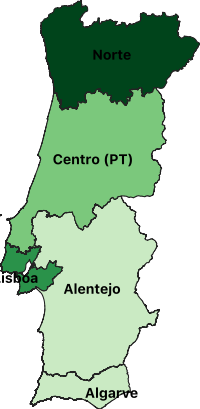

In [7]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

> Seguidamente é possível observar-se o mapa com a respetiva legenda:

![percentagem.png](./Imagens/percentagem.png)

> Para gerar este mapa foi necessário: 

> * em primeiro lugar selecionar na camada _BGRI11_CONT_ apenas as linhas cujo NIVEL = 3, então no QGIS aplicou-se um filtro a esta camada para selecionar estes mesmos itens;

> * Depois, uniu-se a camada _NUTSII_percentagem_casos2_ com a camada _BGRI11_CONT_ através do _localId_ e do _GEO_COD_;

> * Por sua vez, foi necessário unir à camada resultante desta união, a camada _covid_pt_latest_distrito_. Uma vez que, nesta camada estavam presentes os destritos e não a região a que estes pertencem, criou-se uma coluna chamada _id_regiao_ para se depois poder unir à camada anterior. id_regiao = 15 corresponde ao Algarve, id_regiao = 18 ao Alentejo, id_regiao = 15 ao Algarve, id_regiao = 11 ao Norte e, por fim, id_regiao= 17 corresponde à Área Metropolitana de Lisboa.

> * Uma vez unidas todas as camadas, realizou-se uma query sql para somar o número de casos de cada distrito para posteriormente serem guardados numa coluna na camada _NutsII_Join_Censos_". Seguidamente apresenta-se um exemplo desta query para o caso do Algarve:

![casos_Algarve.png](./Imagens/casos_Algarve.png)

> * Criou-se a coluna _CasosConfirmados_ na tabela _NutsII_Join_Censos_:

![adicionar_coluna.png](./Imagens/adicionar_coluna.png)

> * Preenchou-se então a coluna anterior com os valores de casos confirmados calculados anteriormente. 

![adicionar_casos_Algarve.png](./Imagens/adicionar_casos_Algarve.png)

> * Por último, para calcular a percentagem de casos confirmados foi necessário dividir a coluna _CasosConfirmados_ pela coluna _BRGI11_CONT_N_INDIVIDUOS_RESIDENT_ e depois multiplicar por 100. Isto foi feito no QGIS utilizando a _Calculadora de Campos_. Foi assim criada a coluna _percentagem_casos_confirmados_:

![calcular_percentagem.png](./Imagens/calcular_percentagem.png)